In [ ]:
import sys
!{sys.executable} -m pip install yellowbrick

In [68]:
import pandas as pd
import numpy as np
import datetime as dt
from collections import Counter, defaultdict

from gensim.models.word2vec import Word2Vec

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.pipeline import make_pipeline
from sklearn import svm, preprocessing
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.externals import joblib

from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ClassBalance
from yellowbrick.classifier import ClassPredictionError
from yellowbrick.classifier import ConfusionMatrix
from yellowbrick.features.importances import FeatureImportances

import matplotlib.pyplot as plt

import warnings; warnings.simplefilter('ignore') # don't print warnings

In [69]:
pd.options.display.max_seq_items = 2000
pd.options.display.max_columns = None
TRAIN_SET_PATH = 'data.csv'

# Source columns will be merged into our feature set
source_cols = ['TransactionDescription', 'TransactionLineAmount']

# Feature we want to predict
target_col = 'GeneralLedgerAccountCode'

# Take only letters and spaces from a string
def clean(word):
    return ''.join(letter for letter in word if (letter.isalpha() | letter.isspace()))

In [70]:
# Data prep and cleanup
data = pd.read_csv(TRAIN_SET_PATH)

# We have some invalid rows, remove them
data_clean = data.query("TransactionLineId != '00000000-0000-0000-0000-000000000000'")

#This just makes sure our indexes don't skip, makes debugging easier :)
data_clean = data_clean.reset_index(drop=True)

# Give us all lowercase strings
data_clean = data_clean.apply(lambda x: x.astype(str).str.lower())

In [71]:
# Take only the classes with 300 or more training examples. We can raise or lower this later. 
base_class_list = data_clean[target_col].value_counts().reset_index(name="count").query("count > 300")["index"]

# Limit our training set to our base classes
base_set = data_clean.loc[data_clean[target_col].isin(base_class_list)]

# Make sure our indexes don't skip ... makes debugging easier
base_set = base_set.reset_index(drop=True)

In [72]:
# Here, we will build our vocabulary to train word2vec.  We only want to use description.
strings = data_clean[source_cols[0]]

# Make sure we only letters and spaces (no numbers or special characters)
# TODO: Validate this is okay with the languages we are using
words = [word for word in map(clean, strings) if word]

# Get only the unique sentences
word_list = set(words)

# Create our vocabulary.  Remove extra whitespace in the middle, begining and end of our sentences.
X_vocab = []
for s in word_list:
    no_doubles = ' '.join(s.split())
    no_white = no_doubles.strip()
    X_vocab.append(no_white.split())

In [73]:
# Train Word2Vec on our vocabulary and create a dictionary with our words and our embeddings.
model = Word2Vec(X_vocab, size=100, window=5, min_count=1, workers=2)
w2v = {w: vec for w, vec in zip(model.wv.index2word, model.wv.syn0)}

In [74]:
w2v['fournituren']

array([ 4.1940869e-03, -2.5889097e-04, -3.0706043e-03, -4.7018924e-03,
        5.0224416e-04, -2.0809188e-03,  4.3000309e-03,  7.1966596e-04,
       -1.6924402e-03,  2.3372939e-03,  5.3181592e-04,  1.4476086e-03,
        4.6033934e-03, -1.9874994e-03,  5.0843501e-04,  1.2912590e-03,
       -1.3334529e-03, -9.9903857e-04,  3.3913896e-04, -3.9848508e-03,
        8.6652150e-04,  1.4033996e-03, -1.9527283e-03, -2.1664833e-03,
        4.0276940e-03,  3.8655363e-03,  1.7783141e-03, -7.0655858e-04,
        4.2578322e-04,  3.1673876e-04, -2.3093953e-04, -1.6279315e-03,
       -2.9956060e-03,  1.1266383e-03,  3.0450821e-03, -3.6579666e-03,
       -1.3441836e-03,  4.7270870e-03,  8.1681844e-04,  2.9916305e-03,
       -3.9236431e-04, -3.4738623e-04,  3.8702718e-03,  5.7185540e-04,
        3.0044145e-03,  2.9082713e-04,  2.6969370e-03, -1.3269646e-03,
        1.8579584e-03, -7.2578137e-04, -1.0203366e-03,  2.3883141e-03,
       -4.1034380e-03, -2.8801775e-03, -4.4950279e-03, -1.1861335e-03,
      

In [75]:
# This class will provide a mean value embedding vectorizer.  That is, for a sentence, it will take each word
# vectorize it and then take the mean of those vectors and return a single vector.
# It defines "fit" and "transform" so it can fit into a python pipeline
class MeanEmbeddingVectorizer(object):
    def __init__(self, word2vec):
        self.word2vec = word2vec
        if len(word2vec)>0:
            self.dim=len(word2vec[next(iter(w2v))])
        else:
            self.dim=0
            
    def fit(self, X, y):
        return self 

    def transform(self, X):
        retVal = []
        for line in X:
            temp = np.array(np.mean([self.word2vec[w] for w in line.split() if w in self.word2vec] 
                                or [np.zeros(self.dim)], axis=0))
            retVal.append(temp)
        return retVal

In [76]:
# Here, we will create our training set and our test set.
X = base_set[source_cols]
y = base_set[target_col]

# For each sentence (description) in our training set, create a word embedding 
word_embed = MeanEmbeddingVectorizer(w2v).transform(X.iloc[:,0])

# Wrap it into a dataframe
embedding_df = pd.DataFrame(data=word_embed)

# Add the word embeddings to our dataframe
df2 = X.join(embedding_df, lsuffix='_X', rsuffix='_df2')

# Add our lables into our dataframe to make sure all transforms happen to both sets
df2 = df2.join(y, lsuffix='_df2', rsuffix="_y")

# Filter out rows that we did not get a word embedding for
df2 = df2.loc[df2[0] != 0.000000]

# Now we have embeddings, we don't need the descritption
df2 = df2.drop(['TransactionDescription'], axis=1)

# Split off our test set again
y = df2[target_col]

# Drop our lables from our training set
X = df2.drop([target_col], axis=1)
X.shape, y.shape

((11434, 101), (11434,))

In [77]:
# Now we have a clean data set and lable set with word embeddings as well as all other columns we think are relevant
# split into our train and test set making sure we have roughly equal representation across our classes
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1, stratify=y)

X_train

,TransactionLineAmount,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,86,87,88,89,90,91,92,93,94,95,96,97,98,99
9873,1682.97,-3.334617e-03,-0.000186,0.002753,-0.003938,0.000515,0.003610,0.000586,0.000912,0.000998,0.000651,0.001485,-0.000155,0.002383,-0.001818,0.003771,-0.004241,-0.003170,0.002685,-0.000208,-0.000180,0.000630,-0.002061,-0.004822,-0.003153,-0.002023,0.000939,-0.002530,-0.001321,0.003264,0.000672,-0.002050,-0.003959,-0.002411,0.003245,-0.000208,0.002862,0.001044,-0.003365,-0.001668,-0.002251,-0.006651,0.003995,0.003594,-0.000268,0.002061,-0.000403,0.001305,0.000220,0.001003,0.004053,-0.000161,0.004027,0.000457,0.001004,-0.000685,-0.001835,0.004694,-0.001007,-0.001268,0.001606,0.005131,-0.001318,-0.004931,0.002440,0.002665,0.000232,-0.005162,-0.001123,0.002525,0.001380,0.004050,-0.002513,-0.002342,0.001270,-0.001627,0.004646,0.001970,0.005828,-0.003360,0.001725,-0.002358,-0.001499,0.005449,0.001342,-0.001436,0.001129,0.000675,0.000258,-0.000134,-0.003120,0.001093,0.001103,0.003092,-0.002701,-0.001131,0.000090,-0.000398,3.480743e-03,0.001215,0.003054
189,0.95,2.493325e-03,-0.002590,-0.000079,0.001742,-0.002545,-0.001508,0.004583,-0.001178,-0.001168,-0.000243,-0.003425,-0.001161,-0.002172,-0.000183,0.004144,-0.005396,-0.001038,-0.000797,-0.000501,-0.001536,-0.000232,0.001414,0.002011,0.000186,0.000427,-0.002213,-0.000244,-0.002382,-0.001697,-0.002944,-0.000551,-0.000676,-0.000311,0.001456,0.000983,0.002594,-0.004062,0.004485,-0.003297,0.000327,0.004442,0.000484,-0.003626,-0.001772,0.001540,0.001141,-0.002713,-0.003428,0.000703,0.002064,-0.002614,0.002394,0.001596,0.001663,0.003730,-0.002818,-0.001631,-0.000116,-0.000197,-0.002625,-0.001292,0.000766,-0.003278,0.000478,-0.000955,-0.003645,-0.002911,0.004563,-0.000017,-0.003609,-0.002752,0.000436,0.000925,0.000498,0.000677,0.001226,-0.000433,-0.000168,-0.001805,-0.004149,0.001236,-0.002772,0.002259,0.003935,-0.001801,0.003448,-0.000586,0.000309,0.001327,0.003643,-0.001097,0.000115,-0.003504,-0.003495,-0.000327,-0.001094,0.000787,-2.198108e-03,-0.000172,-0.000443
6659,11483.5,3.361274e-03,-0.001688,-0.001498,-0.001570,0.005888,0.000855,-0.000713,-0.004449,-0.005251,0.002348,0.001673,-0.000717,0.005147,0.000700,-0.003594,-0.004518,-0.000880,0.005257,-0.003040,-0.004017,-0.003976,0.005077,0.001696,-0.003251,0.003096,-0.001553,0.000581,0.003567,-0.000535,0.000894,-0.005152,-0.004016,-0.004258,-0.001822,0.001423,-0.002541,-0.003828,-0.001704,0.005056,-0.004225,-0.000380,0.004000,0.000823,0.001029,-0.003167,0.000705,0.004526,-0.003259,0.003748,-0.000025,-0.001055,0.002154,-0.003663,-0.000724,0.005101,-0.002527,-0.001383,-0.005476,-0.002255,0.000172,0.002488,0.003666,0.002793,-0.004375,0.005982,-0.003258,0.004359,-0.003172,0.001461,0.004727,-0.000528,0.001291,-0.005345,0.002088,0.003280,0.002751,0.001547,0.001871,0.001932,0.005088,0.003493,-0.004470,0.002847,0.001324,-0.001985,0.000836,-0.000758,-0.000456,0.000382,0.000731,-0.003233,0.004345,0.001793,0.003511,-0.002486,-0.002528,0.001822,-3.975185e-03,0.001330,0.000341
5234,2491.0,-2.641358e-03,0.001911,0.003824,-0.000409,0.001379,0.003307,0.002308,0.001776,-0.000347,0.004802,0.001455,0.006118,0.006799,0.001615,-0.002325,-0.005612,-0.003156,0.002099,-0.001909,-0.002174,-0.000163,0.002754,-0.002473,-0.001261,-0.002876,-0.000162,-0.005383,-0.002278,0.001917,0.001114,-0.001785,0.000116,-0.001846,-0.000038,0.002036,0.001093,0.000935,-0.000240,0.000776,-0.005373,-0.007101,0.004832,-0.003378,0.003027,-0.002325,-0.000121,0.000662,-0.001172,-0.002565,-0.001973,0.000018,0.001456,0.001492,0.001973,0.000789,-0.003997,-0.001185,-0.005502,-0.001357,0.000510,0.005319,0.005029,0.000788,0.002042,0.002702,0.000051,-0.003617,0.002466,0.000151,0.002203,-0.000270,0.002332,-0.001505,0.002246,-0.002414,0.005498,-0.003313,0.001735,0.001364,0.003061,0.

In [78]:
#classifier = svm.SVC(probability=True)
#classifier = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(15), random_state=1)
classifier = ExtraTreesClassifier(n_estimators=200)

In [79]:
#pl = make_pipeline(StandardScaler(), PCA(n_components=2), classifier)
#pl.fit(X_train, y_train)
classifier.fit(X_train, y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [80]:
#print(pl.score(X_train, y_train))
#print(pl.score(X_test, y_test))
print(classifier.score(X_train, y_train))
print(classifier.score(X_test, y_test))

0.9949710287525965
0.8780061215566244


In [94]:
# persist the model
joblib.dump(classifier, './jpa/model-{}.pkl'.format(dt.datetime.now().strftime("%Y-%m-%d-%H%M%S")))

['./jpa/model-2018-06-25-213442.pkl']

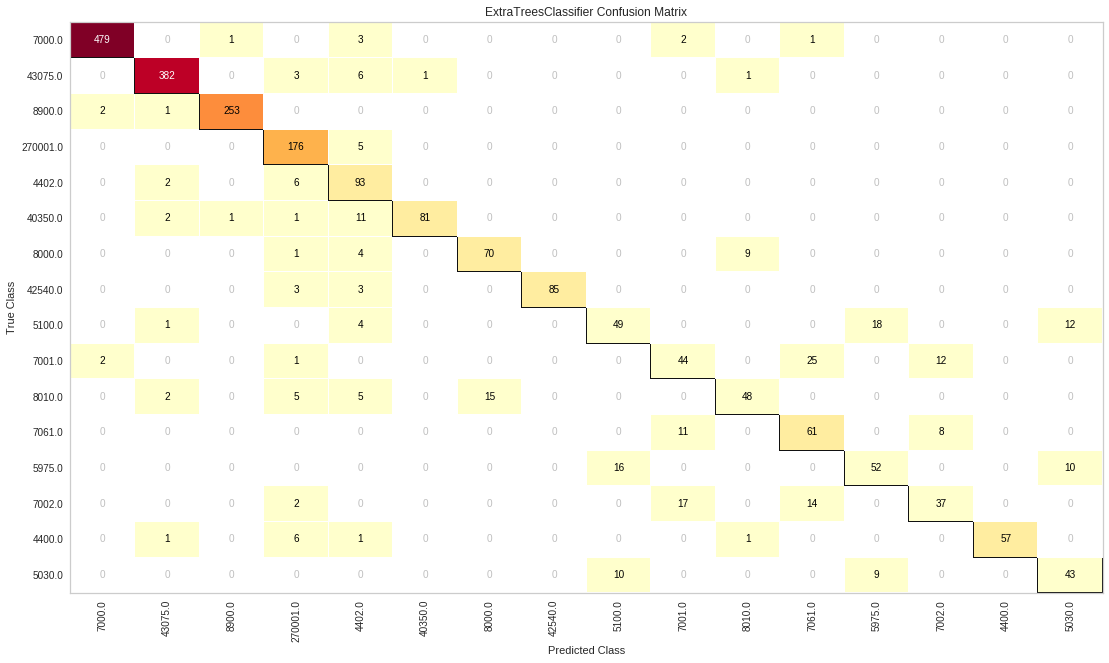

In [38]:
visualizer = ConfusionMatrix(classifier, classes=base_class_list)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

for label in visualizer.ax.texts:
    label.set_size(12)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)

visualizer.poof()

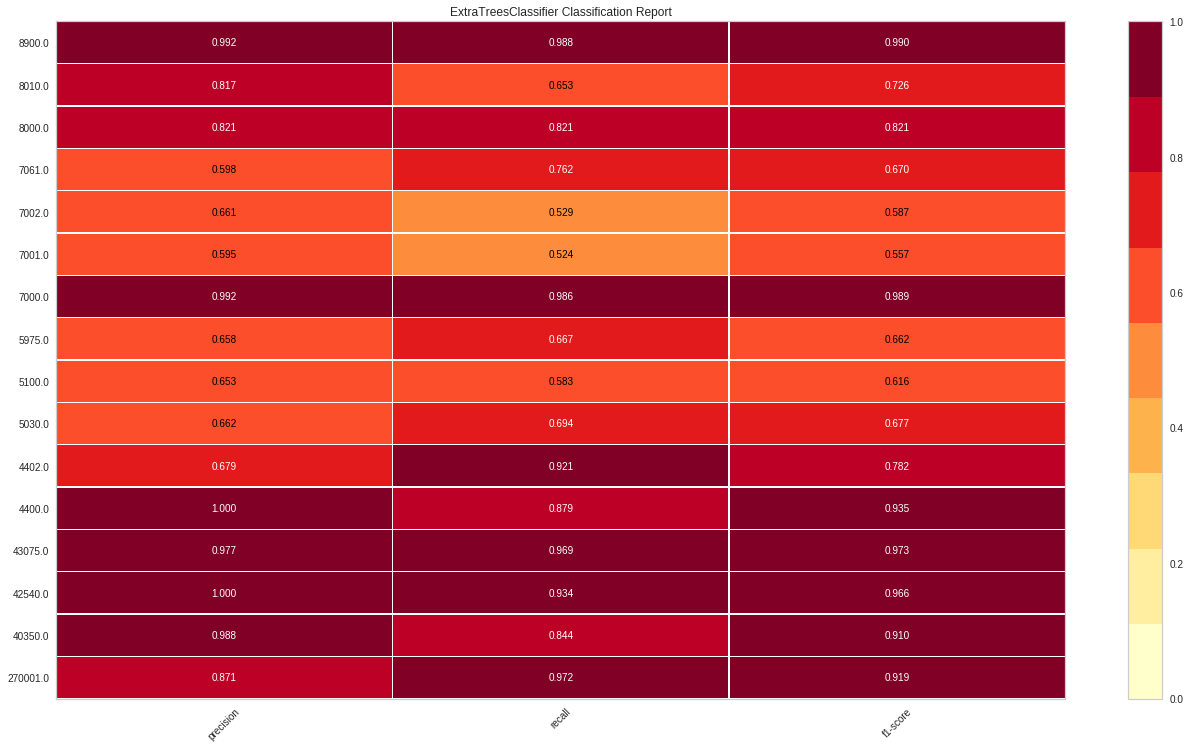

In [39]:
visualizer = ClassificationReport(classifier)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

for label in visualizer.ax.texts:
    label.set_size(12)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
    
visualizer.poof()

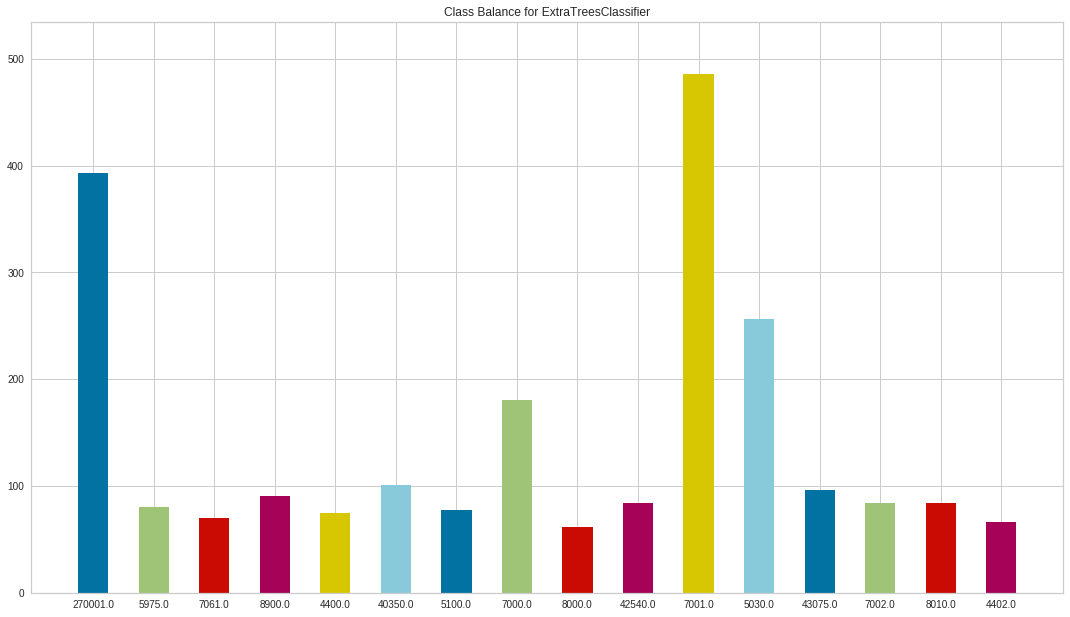

In [40]:
visualizer = ClassBalance(classifier, classes=base_class_list)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

for label in visualizer.ax.texts:
    label.set_size(12)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
    
visualizer.poof()

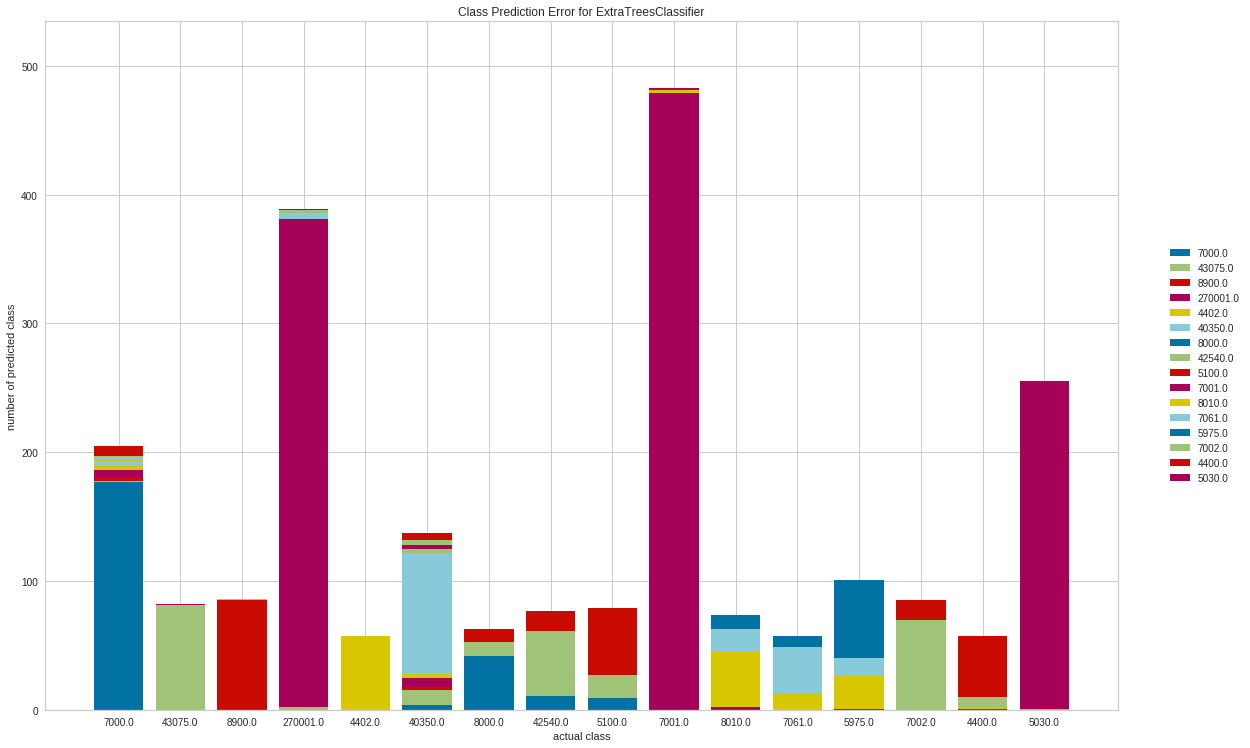

In [95]:
visualizer = ClassPredictionError(classifier, classes=base_class_list)

fig = plt.gcf()
fig.set_size_inches(18.5, 10.5)

for label in visualizer.ax.texts:
    label.set_size(12)

visualizer.fit(X_train, y_train)
visualizer.score(X_test, y_test)
    
visualizer.poof()

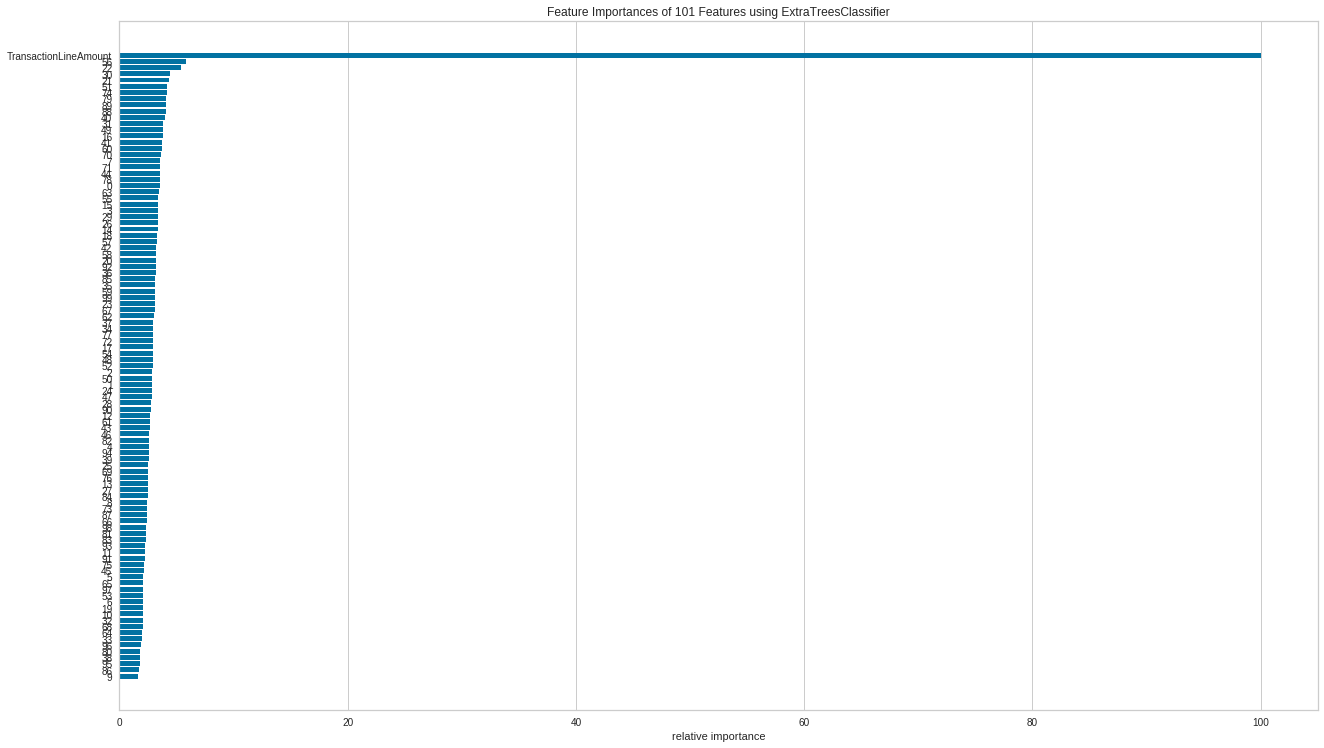

In [96]:
fig = plt.figure()
ax = fig.add_subplot()

fig.set_size_inches(18.5, 10.5)

for label in visualizer.ax.texts:
    label.set_size(16)

vizualizer = FeatureImportances(classifier, ax=ax)
vizualizer.fit(X_train, y_train)

vizualizer.poof()